## Conv1D USPS

In [1]:
import sys
sys.path.insert(0, '..')

In [19]:
import numpy as np
import matplotlib.pyplot as plt

from activation import ReLU
from convolution.conv1D import Conv1D
from convolution.flatten import Flatten
from convolution.maxPool1D import MaxPool1D
from enums import GradientDescentMode
from linear import Linear
from loss import CELoss
from sequential import Sequential
from optimizers import SGD
from utils import onehot_encoding

from sklearn.model_selection import train_test_split

In [3]:
plt.style.use('seaborn-whitegrid')

### USPS

In [4]:
def load_usps(fn):
    with open(fn,"r") as f:
        f.readline()
        data = [[float(x) for x in l.split()] for l in f if len(l.split())>2]
    tmp=np.array(data)
    return tmp[:,1:],tmp[:,0].astype(int)

def get_usps(l,datax,datay):
    if type(l)!=list:
        resx = datax[datay==l,:]
        resy = datay[datay==l]
        return resx,resy
    tmp = list(zip(*[get_usps(i,datax,datay) for i in l]))
    tmpx,tmpy = np.vstack(tmp[0]),np.hstack(tmp[1])
    return tmpx,tmpy

def show_usps(data):
    plt.imshow(data.reshape((16,16)),interpolation="nearest")

In [5]:
usps_train_val_x, usps_train_val_y = load_usps("data/USPS_train.txt")
usps_train_x, usps_val_x, usps_train_y, usps_val_y = train_test_split(usps_train_val_x, usps_train_val_y, test_size=.2, random_state=42)
usps_test_x, usps_test_y = load_usps("data/USPS_test.txt")

usps_train_x = usps_train_x.reshape(-1, 256, 1)
usps_val_x = usps_val_x.reshape(-1, 256, 1)
usps_test_x = usps_test_x.reshape(-1, 256, 1)

print('Train shape :', usps_train_x.shape, usps_train_y.shape)
print('Validation shape :', usps_val_x.shape, usps_val_y.shape)
print('Test shape :', usps_test_x.shape, usps_test_y.shape)

Train shape : (5832, 256, 1) (5832,)
Validation shape : (1459, 256, 1) (1459,)
Test shape : (2007, 256, 1) (2007,)


In [6]:
usps_train_onehot_y = onehot_encoding(usps_train_y, 10)
usps_val_onehot_y = onehot_encoding(usps_val_y, 10)
usps_test_onehot_y = onehot_encoding(usps_test_y, 10)
print('One hot train :', usps_train_onehot_y.shape)
print('One hot val :', usps_val_onehot_y.shape)
print('One hot test :', usps_test_onehot_y.shape)

One hot train : (5832, 10)
One hot val : (1459, 10)
One hot test : (2007, 10)


In [7]:
def eval_fn(net, X_test, y_test):
    y_pred = net(X_test).argmax(1)
    y_test = y_test.argmax(1)
    return np.mean(y_pred == y_test)

### Conv1D(3,1,32) → MaxPool1D(2,2) → Flatten() → Linear(4064,100) → ReLU() → Linear(100,10) → BCE

In [26]:
net = Sequential(
    Conv1D(3, 1, 32, 1),
    MaxPool1D(2, 2),
    Flatten(),
    Linear(4064, 100),
    ReLU(),
    Linear(100, 10)
)

lr = 1e-1
epochs = 10_000
loss = CELoss()
all_loss, all_loss_valid, all_acc_valid, best_parameters = SGD(
    net,
    loss,
    lr,
    usps_train_x,
    usps_train_onehot_y,
    epochs,
    GradientDescentMode.BATCH,
    -1,
    eval_fn,
    usps_val_x,
    usps_val_onehot_y
)

Train : -----------------------------------
Epoch 1000: train loss: 0.12782470853008962 val loss: 0.15791106341757438 val eval_fn: 0.95407813570939
Epoch 2000: train loss: 0.0807070878931431 val loss: 0.1317713218495016 val eval_fn: 0.9609321453050035
Epoch 3000: train loss: 0.05444010445013918 val loss: 0.12060589811619846 val eval_fn: 0.9664153529814942
Epoch 4000: train loss: 0.03812554279663497 val loss: 0.1160116180923383 val eval_fn: 0.969842357779301
Epoch 5000: train loss: 0.028084549727872044 val loss: 0.11455513307020593 val eval_fn: 0.9691569568197396
Epoch 6000: train loss: 0.021625144971340757 val loss: 0.11448219881044103 val eval_fn: 0.9705277587388622
Epoch 7000: train loss: 0.017254218209716527 val loss: 0.1151578044969517 val eval_fn: 0.969842357779301
Epoch 8000: train loss: 0.014160890753204055 val loss: 0.11617757426493637 val eval_fn: 0.969842357779301
Epoch 9000: train loss: 0.011895961712586736 val loss: 0.11731479722440714 val eval_fn: 0.9712131596984236
Epoch 

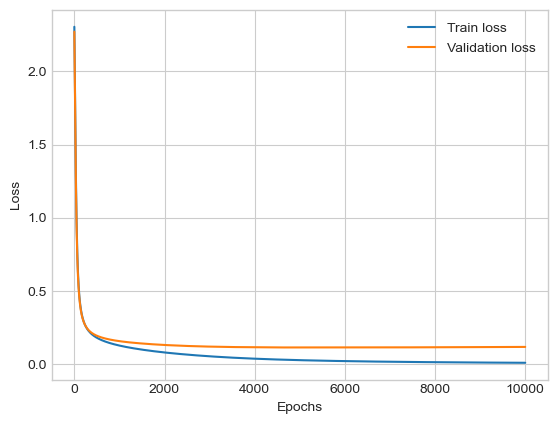

In [27]:
plt.plot(all_loss, label='Train loss')
plt.plot(all_loss_valid, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

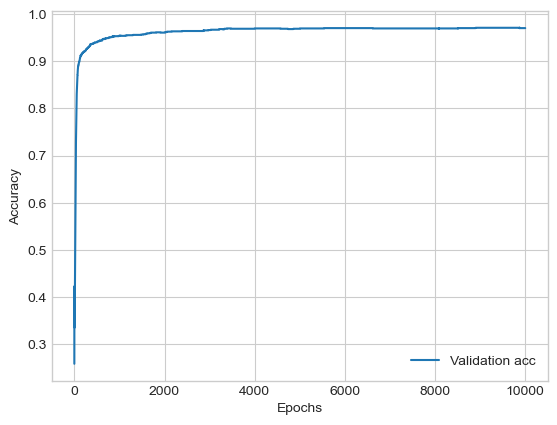

In [28]:
plt.plot(all_acc_valid, label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [30]:
net.set_parameters(best_parameters)
print('Test acc :', eval_fn(net, usps_test_x, usps_test_onehot_y))

Test acc : 0.9372197309417041


In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(net, X, y):
    y_pred = net(X).argmax(1)
    cm = confusion_matrix(y, y_pred)
    sns.set(font_scale=1)
    sns.heatmap(cm, annot=True, annot_kws={"size": 10}, cmap='Blues', fmt='g')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()

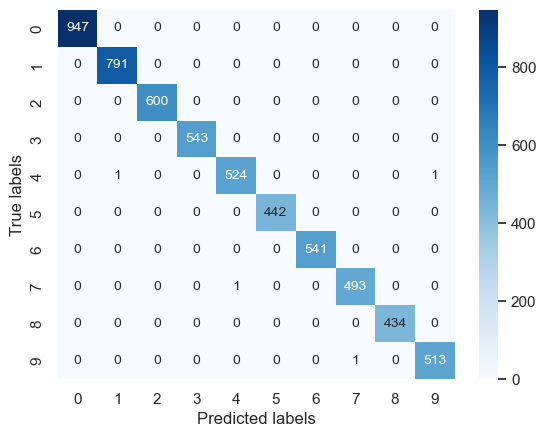

In [31]:
plot_confusion_matrix(net, usps_train_x, usps_train_y)

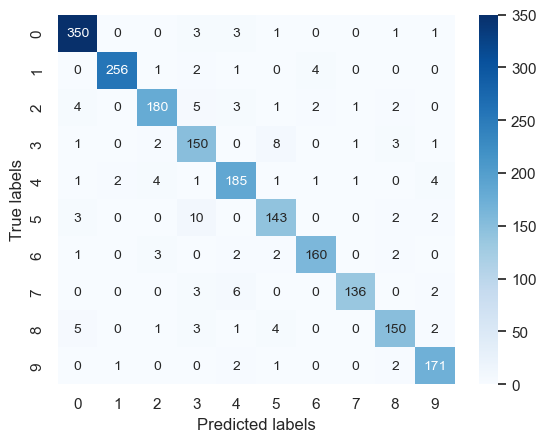

In [32]:
plot_confusion_matrix(net, usps_test_x, usps_test_y)

In [33]:
print('Train accuracy :', eval_fn(net, usps_train_x, usps_train_onehot_y))

Train accuracy : 0.9993141289437586


In [34]:
print('Train accuracy :', eval_fn(net, usps_test_x, usps_test_onehot_y))

Train accuracy : 0.9372197309417041
